In [4]:
""""
Figaro times collection times script. 
"""
import numpy as np
import pandas as pd
import os
from openpyxl import load_workbook, Workbook
from openpyxl.utils.cell import get_column_letter

path_src = "/local/scratch/Figaro/figaro-code"
exp_names = ["figaro", "mkl"]
exp_paths = {"figaro": "comparisons/performance/lapack", "mkl": "comparisons/performance/python/mkl"}
db_names = ["DBRetailer", "DBFavorita", "DBYelp"]

start_per = 10
end_per = 100
per_inc = 10

num_measurement = 5

xlsx_name = "time.xlsx"

df_measurement_exps = {}
for exp_name in exp_names: 
    exp_path = exp_paths[exp_name]
    perf_path = os.path.join(path_src, exp_path)
    df_measurement = pd.DataFrame(columns=db_names)

    for db_name in db_names:
        #gather_times_path = os.path.join(perf_path, db_name + xlsx_name)
        #print(gather_times_path)
        #out_workbook = Workbook()
        #out_workbook.remove(out_workbook.active)
        #out_sheet = out_workbook.create_sheet("Times")

        for db_idx, percent in enumerate(range(start_per, end_per + 1, per_inc)): 
            db_name_per = "{}PK1C{}".format(db_name, percent)
            path_xlsx = os.path.join(perf_path, db_name_per, xlsx_name)
            workbook = load_workbook(filename=path_xlsx, data_only=True)
            sheet = workbook.active
            row_count = sheet.max_row
            col_idx = db_idx + 1
            col_letter = get_column_letter(col_idx)
            
            #out_sheet.cell(row=1, column=col_idx).value = db_name_per
            
            start_row_idx = 2
            np_measures = np.zeros(num_measurement)
            for row_idx_dst in range(start_row_idx, start_row_idx + num_measurement):
                offset_idx = row_idx_dst - start_row_idx
                row_idx_src = row_count - num_measurement  + offset_idx
                val = sheet.cell(row=row_idx_src, column=2).value
                np_measures[offset_idx] = float(val)
                #print(idx_shift, db_idx)
                #out_sheet.cell(row=row_idx_dst, column=col_idx).value = val
            
            #out_sheet.cell(row=start_row_idx + num_measurement, column=col_idx).value = '=AVERAGE({}{}:{}{})'.format(col_letter, start_row_idx + 1, 
            #        col_letter,6)

            time_avg = np.mean(np_measures[1:])
            df_measurement.at[percent, db_name] = time_avg
            
        #out_workbook.save(gather_times_path)
        print(df_measurement)
        df_measurement.index = df_measurement.index.set_names(['index'])
        df_measurement = df_measurement.astype(float)
    df_measurement_exps[exp_name] = df_measurement





    DBRetailer DBFavorita DBYelp
10      2.8976        NaN    NaN
20     6.41265        NaN    NaN
30     9.98756        NaN    NaN
40     14.0823        NaN    NaN
50     18.0243        NaN    NaN
60     22.2522        NaN    NaN
70      27.518        NaN    NaN
80     34.6023        NaN    NaN
90     37.8981        NaN    NaN
100    44.0685        NaN    NaN
       DBRetailer  DBFavorita  DBYelp
index                                
10       2.897600    3.349989     NaN
20       6.412651    9.011400     NaN
30       9.987557   12.613609     NaN
40      14.082324   17.639892     NaN
50      18.024264   22.133238     NaN
60      22.252194   27.257848     NaN
70      27.518038   36.669080     NaN
80      34.602267   38.316961     NaN
90      37.898119   44.573885     NaN
100     44.068528   51.690823     NaN
       DBRetailer  DBFavorita    DBYelp
index                                  
10       2.897600    3.349989  0.160560
20       6.412651    9.011400  0.144240
30       9.987557   1

In [5]:
import csv

db_name_map = {
    "DBFavorita": "exp1perf-favorita.dat", 
    "DBRetailer": "exp1perf-retailer.dat", 
    "DBYelp": "exp1perf-yelp.dat"
    }
exp_dat_names = ["#percentage of data", "figaro-time", "mkl-time"]

for db_name in db_names:
    dbs_results = []
    for exp_name in exp_names:
        dbs_results.append(df_measurement_exps[exp_name][db_name])
    df_db_results = pd.concat(dbs_results, axis=1)
    df_db_results = df_db_results.reset_index().rename(columns={df_db_results.index.name:'index'})
    df_db_results.columns = exp_dat_names
    df_db_results.to_csv(db_name_map[db_name], float_format='%.2f', sep='\t', index=False, quoting=csv.QUOTE_NONE,  escapechar=" ")

{'figaro':        DBRetailer  DBFavorita    DBYelp
index                                  
10       2.897600    3.349989  0.160560
20       6.412651    9.011400  0.144240
30       9.987557   12.613609  0.152247
40      14.082324   17.639892  0.157466
50      18.024264   22.133238  0.166203
60      22.252194   27.257848  0.177785
70      27.518038   36.669080  0.186430
80      34.602267   38.316961  0.187385
90      37.898119   44.573885  0.188257
100     44.068528   51.690823  0.190660, 'mkl':        DBRetailer  DBFavorita     DBYelp
index                                   
10       4.541525    5.606832   1.820388
20       8.381183   13.035158   3.076270
30      13.696878   21.795078   4.507036
40      18.084897   23.085856   6.125255
50      23.493895   28.327437   7.595593
60      29.076157   35.071836   9.482214
70      41.058638   41.878891  12.308652
80      49.173383   48.852601  14.252931
90      56.614383   59.472896  13.000754
100     63.847990   64.822168  14.243517}
figaro
i

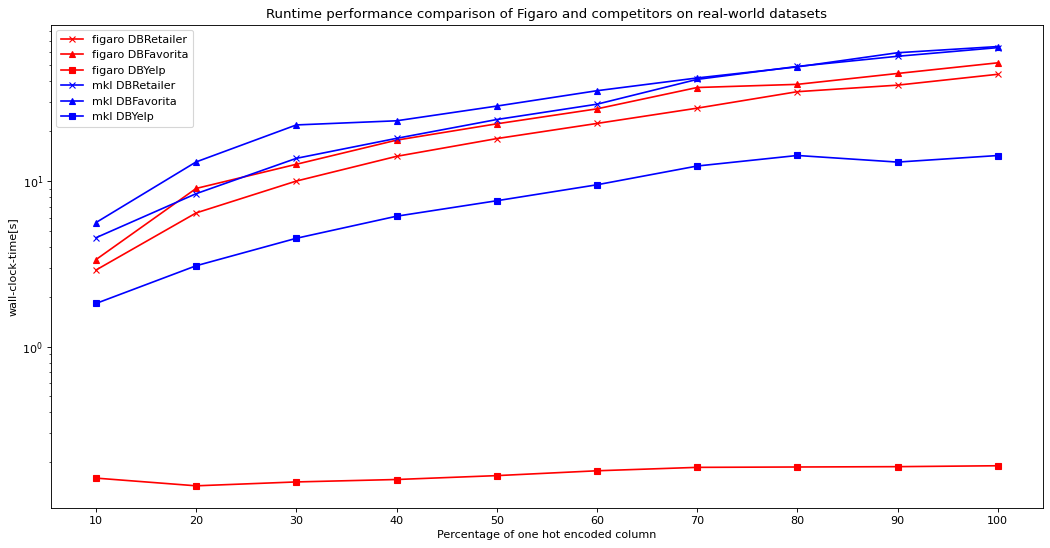

In [6]:
import matplotlib.pyplot as plt

plt.figure("name", figsize=(16, 8), dpi=80)
plt.xlabel("Percentage of one hot encoded column")
plt.ylabel("wall-clock-time[s]")

plt.title("Runtime performance comparison of Figaro and competitors on real-world datasets")

plt.yscale('log', base=10)
plt.locator_params(axis='x', nbins=6)
plt.locator_params(axis='x', nbins=10)
db_marker =  {"DBFavorita": "^", "DBYelp": "s", "DBRetailer": "x"}
exp_colour = {"figaro": "r", "mkl": "b"}

print(df_measurement_exps)
for exp_name in exp_names:
    print(exp_name)
    df_measurement = df_measurement_exps[exp_name]
    for db_name in df_measurement:
        print(df_measurement[db_name])
        plt.plot(df_measurement[db_name], "-" + exp_colour[exp_name] + db_marker[db_name], label="{} {}".format(exp_name, db_name))
plt.legend(loc="upper left")

plt.show()